In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_distances

In [ ]:
user_item_interactions = pd.DataFrame([
    [0, 1, 1, 0, 0],
    [0, 0, 1, 0, 1],
    [1, 0, 0, 0, 0],
    [1, 0, 0, 1, 0],
    [0, 0, 1, 1, 1]
])

In [ ]:
melted_interactions = (
    user_item_interactions
    .reset_index(names='user_id')
    .melt(id_vars='user_id', var_name='item_id')
)

In [ ]:
# Train-Test split
melted_interactions_train, melted_interactions_test = train_test_split(
  melted_interactions,
  stratify=melted_interactions['user_id']
)

melted_interactions_train = melted_interactions

In [ ]:
# Dataloaders
dataset_train = TensorDataset(
  torch.IntTensor(melted_interactions_train['user_id'].astype('int').values),
  torch.IntTensor(melted_interactions_train['item_id'].astype('int').values),
  torch.Tensor(melted_interactions_train['value'].astype('float').values),
)
dataset_test = TensorDataset(
  torch.IntTensor(melted_interactions_test['user_id'].astype('int').values),
  torch.IntTensor(melted_interactions_test['item_id'].astype('int').values),
  torch.Tensor(melted_interactions_test['value'].astype('float').values),
)

In [ ]:
class UserUserCollaborativeFiltering():

  def __init__(self, k_neighbors: int=5) -> None:
    self.k_neighbors = k_neighbors

  def fit(self, user_index: torch.IntTensor, item_index: torch.IntTensor, values: torch.Tensor):
    sparse_interactions = torch.sparse_coo_tensor(
      torch.stack((user_index, item_index)),
      values
    )
    interactions = sparse_interactions.to_dense().numpy()
    user_distances = cosine_distances(interactions)
    np.fill_diagonal(user_distances, np.inf)

    user_neighbors = user_distances.argsort()[:, :self.k_neighbors]
    self.predicted_recommendations = interactions[user_neighbors, :].mean(axis=1)
    return self

  def predict(self, user_index: torch.IntTensor, item_index: torch.IntTensor):
    return torch.Tensor(self.predicted_recommendations[user_index, item_index])

In [ ]:
user_index, item_index, values = dataset_train[:]
model = UserUserCollaborativeFiltering(2).fit(user_index, item_index, values)

In [ ]:
user_index, item_index, values = dataset_test[:]
predictions = model.predict(user_index, item_index)

In [ ]:
values

tensor([0., 1., 1., 1., 0., 0., 1.])

In [ ]:
predictions

tensor([0.5000, 1.0000, 0.5000, 1.0000, 0.5000, 0.5000, 0.5000])

In [ ]:
import networkx as nx

In [1]:
from abc import ABC, abstractmethod
from typing import List


class GraphConstructorStrategy(ABC):
    """
    The Strategy interface declares operations common to all supported versions
    of some algorithm.

    The Context uses this interface to call the algorithm defined by Concrete
    Strategies.
    """

    @abstractmethod
    def from_dataset(cls, dataset: TensorDataset) -> nx.Graph:
        pass


"""
Concrete Strategies implement the algorithm while following the base Strategy
interface. The interface makes them interchangeable in the Context.
"""

class BipartiteGraphConstructorStrategy(GraphConstructorStrategy):
    USER_BIPARTITE_NAME = "user"
    ITEM_BIPARTITE_NAME = "item"

    @classmethod
    def add_users(cls, graph: nx.Graph, user_index: torch.IntTensor) -> None:
      users = [f"u{id_}" for id_ in torch.unique(user_index)]
      graph.add_nodes_from(users, bipartite=cls.USER_BIPARTITE_NAME)

    @classmethod
    def add_items(cls, graph: nx.Graph, item_index: torch.IntTensor) -> None:
      items = [f"i{id_}" for id_ in torch.unique(item_index)]
      graph.add_nodes_from(items, bipartite=cls.ITEM_BIPARTITE_NAME)

    @classmethod
    def add_user_item_interactions(cls, graph: nx.Graph, user_index: torch.IntTensor,
                                     item_index: torch.IntTensor, values: torch.Tensor
                                     ) -> None:
      edges = torch.stack((user_index, item_index)).T[values != 0]
      edges = [(f"u{edge[0]}", f"i{edge[1]}") for edge in edges]
      graph.add_edges_from(edges, data=values[values != 0])

    @classmethod
    def from_dataset(cls, dataset: TensorDataset) -> nx.Graph:
      user_index, item_index, values = dataset[:]
      graph = nx.Graph()
      cls.add_users(graph, user_index)
      cls.add_items(graph, item_index)
      cls.add_user_item_interactions(graph, user_index, item_index, values)
      return graph


class Context():
    """
    The Context defines the interface of interest to clients.
    """

    def __init__(self, graph_strategy: GraphConstructorStrategy) -> None:
        """
        Usually, the Context accepts a strategy through the constructor, but
        also provides a setter to change it at runtime.
        """

        self._graph_strategy = graph_strategy

    @property
    def graph_strategy(self) -> GraphConstructorStrategy:
        """
        The Context maintains a reference to one of the Strategy objects. The
        Context does not know the concrete class of a strategy. It should work
        with all strategies via the Strategy interface.
        """

        return self._graph_strategy

    @graph_strategy.setter
    def graph_strategy(self, graph_strategy: GraphConstructorStrategy) -> None:
        """
        Usually, the Context allows replacing a Strategy object at runtime.
        """

        self._graph_strategy = graph_strategy

    def get_graph(self, dataset: TensorDataset) -> None:
        """
        The Context delegates some work to the Strategy object instead of
        implementing multiple versions of the algorithm on its own.
        """
        return self._graph_strategy.from_dataset(dataset)



NameError: name 'TensorDataset' is not defined

In [ ]:
context = Context(BipartiteGraphConstructorStrategy)
graph = context.get_graph(dataset_train)

In [ ]:
for node in graph.nodes:
  second_degree_neighbors = []
  for neighbor in graph.neighbors(node):
    second_degree_neighbors.extend(graph.neighbors(neighbor))
    second_degree_neighbors.remove(node)
  graph.add_edges_from([(node, neighbor) for neighbor in second_degree_neighbors])

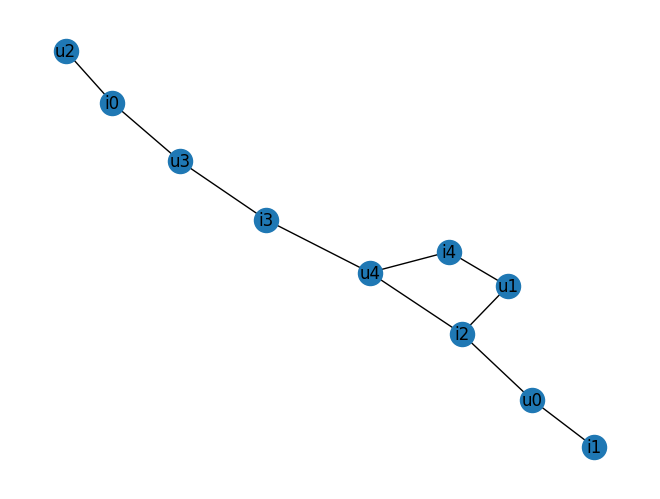

In [ ]:
nx.draw(graph, with_labels=True,
       )

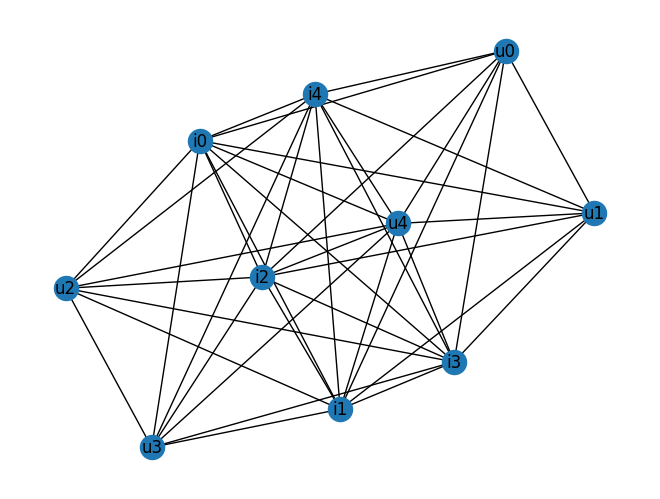

In [ ]:
nx.draw(graph, with_labels=True,
       )

In [ ]:
1+1

2

In [ ]:
2 + 3

5

In [ ]:
a = 5
a  + 12

17